## Исследование объявлений о продаже квартир

Представлен архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры, которые позволят построить автоматизированную систему, которая отследит аномалии и мошенническую деятельность. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [387]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep="\t")
print(data.head())
data.info()

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

### Вывод

Исходный датасет состоит из 22 столбцов и 23699 строк (записей). 15 столбцов содержат в себе пропуски, которые можно разделить на три группы. 1.Больше всего (т.е. более 30 %) имеют пропуски столбцы: принадлежности недвижимости к апартаментам, расстояние до ближайших парка и водоёма, количества балконов, высота потолков. 2.Менее 30 %, но более 20%: расстояния до аэропорта, до центра, количество парков и водоёмов в радиусе 3000 м. 3. Менее 15 %: площади кухни и жилой площади, количества этажей и балконов, населённый пункт, сколько обявление весИт.

### Шаг 2. Предобработка данных

1. Предобработка данных по высоте потолка квартир, площади кухонь, жилой площади

In [388]:
data_CH = data.query('2.4 <= ceiling_height <= 4')
const_ceiling_height_median = data_CH['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(const_ceiling_height_median)
data = data.query('2.4 <= ceiling_height <= 4')


data_KA = data.query('4.9 <= kitchen_area <= 40')
const_kitchen_area_median = data_KA['kitchen_area'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(const_kitchen_area_median)
data = data.query('4.9 <= kitchen_area <= 40')


data_LA = data.query('9 <= living_area <= 180')
const_living_area_median = data_LA['living_area'].median()
data['living_area'] = data['living_area'].fillna(const_living_area_median)
data = data.query('9 <= living_area <= 180')


  По всей видимости эти поля являются необязательными для заполнения и пользователи не утруждают себя,считая эти параметры неважными.

  В итоге по высоте потолка менее 1 % (96 записей из 14504) было отвергнуто как аномалия (или редкое явление), даже если среди них есть реальные данные - их отсутствие не повлияет на общую картину.
  Аналогично поступим с площадями кухонь - ~ 1 % (224 записей из 21421) было отвергнуто как аномалия (или редкое явление).
  Аналогично поступим с жилой площадью - менее 1 % (67 записей из 21796) было отвергнуто как аномалия (или редкое явление).

Пропуски по потолкам, жилой площади и кухни заменяем на значения медианы, полученной после отвержения аномалий.

2. Предобработка данных по количеству этажей

In [389]:
print(data['floors_total'].isna().sum(), 'пропусков')
data.dropna(subset = ['floors_total'], inplace = True)

85 пропусков


  Количество этажей важный критерий (в контексте того, на каком этаже сама квартира), пропусков менее 1 % - удаляем все строки с пропущенными значениями в этом столбце.
  Всего 1% - наверно просто забыли вписать, скорее всего необязательное для заполнения.

3. Предобработка данных по принадлежности к понятию 'апартаменты'

In [390]:
print(data['is_apartment'].isna().sum(), 'пропусков')
print(data['is_apartment'].value_counts())
data['is_apartment'] = data['is_apartment'].fillna(False)
data = data.query('is_apartment == False')

20530 пропусков
False    2681
True       42
Name: is_apartment, dtype: int64


Предлагается апартаменты рассматривать отдельно, делать отдельные исследования, 
потомучто это другой тип недвижимости https://journal.tinkoff.ru/opasnosti-apartamentov/, соответственно и цены будут другие. При этом оставшихся 42 записей (до начала предобработки 50) категорически мало, чтобы делать эти исследования. Нужно больше данных! Поэтому исключаем их.

4. Предобработка данных по количеству балконов.

In [391]:
print(data['balcony'].isna().sum(), 'пропусков')
data['balcony'] = data['balcony'].fillna(0)

11275 пропусков


Eсли человек не указал число балконов — скорее всего, их нет.Такие пропуски правильно заменить на 0.

5. Название населённого пункта является очень важным критерием в рамках задачи.

In [392]:
print(data['locality_name'].isna().sum(), 'пропусков')
data.dropna(subset = ['locality_name'], inplace = True)

47 пропусков


Исключаем из сета ещё объявления без названия населённого пункта, т.к. присутствие такой записи в рамках поставленной задачи не имеет смысла и даже вредна. К счастью их меньше 0,5 процента.

6. Пропущенные данные по расстоянию до аэропорта и центра, по количеству парков и озёр

In [393]:
data_qf = data.query('airports_nearest == "NaN"')
print(data_qf['locality_name'].value_counts().head())
print(data['locality_name'].value_counts().head())

data_qp = data.query('cityCenters_nearest == "NaN"') 
print(data_qp['locality_name'].value_counts().head())
print(data['locality_name'].value_counts().head())

посёлок Мурино     514
Всеволожск         395
Гатчина            303
деревня Кудрово    299
Выборг             231
Name: locality_name, dtype: int64
Санкт-Петербург    15346
посёлок Мурино       514
посёлок Шушары       437
Всеволожск           395
Пушкин               360
Name: locality_name, dtype: int64
посёлок Мурино     514
Всеволожск         395
Гатчина            303
деревня Кудрово    299
Выборг             231
Name: locality_name, dtype: int64
Санкт-Петербург    15346
посёлок Мурино       514
посёлок Шушары       437
Всеволожск           395
Пушкин               360
Name: locality_name, dtype: int64


Пропущенны данные по расстоянию до аэропорта и центра, по количеству парков и озёр - по определённым населённым пунктам. Система (автоматическая) расчёта расстояния несовершенна. Возможно основная причина пропусков связана с особенностями написания названий населённых пунктов. Такие выводы сделаны на основе очерёдной проверки по столбцам 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'ponds_around3000'. Данные пропуски не касаются Санкт-Петербурга, что хорошо, потому что эти параметры больше актуальны для большого города, нежели для посёлков и деревень.

7. Данные по расстоянию до парков и озёр

In [394]:
print(data['parks_nearest'].describe())
data_PAN = data.query('parks_nearest == "NaN"')
print(data_PAN['locality_name'].value_counts().head())
print(data['locality_name'].value_counts().head())

print(data['ponds_nearest'].describe())
data_PON = data.query('ponds_nearest == "NaN"')
print(data_PON['locality_name'].value_counts().head())
print(data['locality_name'].value_counts().head())

count    7858.000000
mean      491.630568
std       341.668664
min         1.000000
25%       288.000000
50%       455.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64
Санкт-Петербург      8251
посёлок Мурино        514
посёлок Шушары        437
Всеволожск            395
посёлок Парголово     317
Name: locality_name, dtype: int64
Санкт-Петербург    15346
посёлок Мурино       514
посёлок Шушары       437
Всеволожск           395
Пушкин               360
Name: locality_name, dtype: int64
count    8824.000000
mean      519.602788
std       277.841042
min        13.000000
25%       295.000000
50%       503.000000
75%       731.000000
max      1344.000000
Name: ponds_nearest, dtype: float64
Санкт-Петербург    7604
посёлок Мурино      514
Всеволожск          395
Гатчина             303
деревня Кудрово     299
Name: locality_name, dtype: int64
Санкт-Петербург    15346
посёлок Мурино       514
посёлок Шушары       437
Всеволожск           395
Пушкин         

По всей видимости автоматическая система не ищет дальше определённого расстояния, а именно для парков - 3190 м, для озёр - 1400 м. (К сожалению, данные пропуски касаются Санкт-Петербурга, что плохо, потому что эти параметры актуальны для большого города, НО, к счастью, не касаются задания)

8. Пропущенные данные по параметру - количество дней "от публикации до снятия"

In [395]:
data_DE = data.query('days_exposition == "NaN"')
print(data_DE['last_price'].median(), 'Медианное значение по пропущенным данным')
print(data['last_price'].median(), 'Медианное значение по всем данным')
print(data_DE['last_price'].mean(), 'Среднее значение по пропущенным данным')
print(data['last_price'].mean(), 'Среднее значение по всем данным')

5550000.0 Медианное значение по пропущенным данным
4600000.0 Медианное значение по всем данным
7901999.137540453 Среднее значение по пропущенным данным
6184361.542048005 Среднее значение по всем данным


По всей видимости эти объявления висят до сих пор, так как выборка по пропущенным значениям в days_exposition имеет бОльшие и по среднему и по медиане значения по столбцу last_price.

Цены выставили этим квартирам выше, чем в среднем.

In [396]:
data.dropna(subset = ['days_exposition'], inplace = True)

Можно исключить эти объявления, потомучто, по всей видимости, цены у них завышены, а значит для нашего исследования они не нужны.

9. Изменение типов данных.

In [397]:
data['is_apartment'] = data['is_apartment'].astype('bool')
#is_apartment подразумевает только два варианта True или False, но это было записано как object

data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
# количество этажей и балконов может быть только целочисленным

data['days_exposition'] = data['days_exposition'].astype('int')
# для наглядности и анализа нет необходимости знать вплоть до часа и минуты сколько висело объявление

In [398]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20074 entries, 1 to 23697
Data columns (total 22 columns):
total_images            20074 non-null int64
last_price              20074 non-null float64
total_area              20074 non-null float64
first_day_exposition    20074 non-null object
rooms                   20074 non-null int64
ceiling_height          20074 non-null float64
floors_total            20074 non-null int64
living_area             20074 non-null float64
floor                   20074 non-null int64
is_apartment            20074 non-null bool
studio                  20074 non-null bool
open_plan               20074 non-null bool
kitchen_area            20074 non-null float64
balcony                 20074 non-null int64
locality_name           20074 non-null object
airports_nearest        15469 non-null float64
cityCenters_nearest     15488 non-null float64
parks_around3000        15488 non-null float64
parks_nearest           6743 non-null float64
ponds_around3000    

По результатам предобработки данных было отвергнуто/удалено 3625 записей, что состовляет 15 % от всего датасета. Это не мало, но они содержали аномалии, которые негативно влияют на общую статистику.

### Шаг 3. Посчитайте и добавьте в таблицу

Цена квадратного метра

In [399]:
data['pr_m2'] = data['last_price'] / data['total_area']
data['pr_m2'] = data['pr_m2'].astype('int')

День недели, месяц и год публикации объявления

In [400]:
data['time'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['year'] = pd.DatetimeIndex(data['time']).year
data['month'] = pd.DatetimeIndex(data['time']).month
data['weekday'] = data['time'].dt.weekday

Этаж квартиры; варианты — первый, последний, другой

In [401]:
def whats_floor(floor):
    if  floor['floor'] == 1:
        return 'первый'
    elif floor['floor'] == floor['floors_total']:
        return 'последний'
    else:
        return 'другой' 
data['stage'] = data.apply(whats_floor, axis = 1) 


# Функция для того чтобы выполнить инструкции в шаге 4 по проверке зависимости
def whats_floor2(floor):
    if  floor['floor'] == 1:
        return '1'
    elif floor['floor'] == floor['floors_total']:
        return '3'
    else:
        return '2' 
data['stage2'] = data.apply(whats_floor2, axis = 1)
data['stage2'] = data['stage2'].astype('int')

Соотношение жилой и общей площади

In [402]:
data['dolya_giloy'] = data['living_area'] / data['total_area']

Отношение площади кухни к общей

In [403]:
data['dolya_kuhni'] = data['kitchen_area'] / data['total_area']

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Изучение параметров: площадь, цена, число комнат, высота потолков. Построение гистограммы для каждого параметра.

In [404]:
import matplotlib.pyplot as plt

площадь
count    20074.000000
mean        57.741310
std         29.037673
min         12.000000
25%         39.500000
50%         50.600000
75%         67.200000
max        500.000000
Name: total_area, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


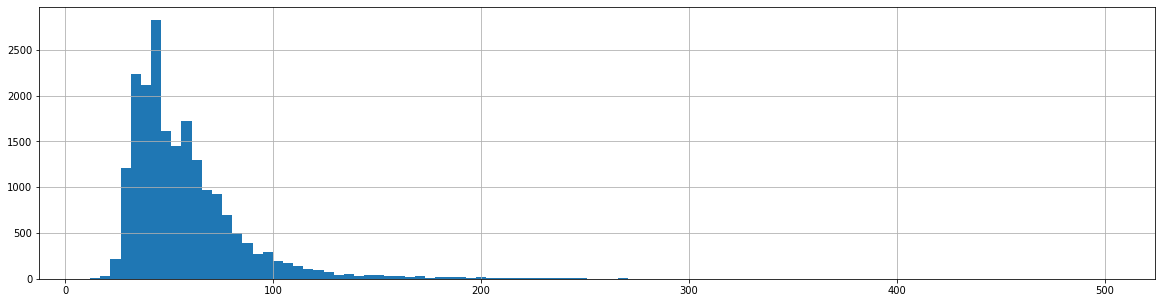

цена
count    2.007400e+04
mean     5.919965e+06
std      7.013473e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.500000e+06
75%      6.450000e+06
max      3.300000e+08
Name: last_price, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


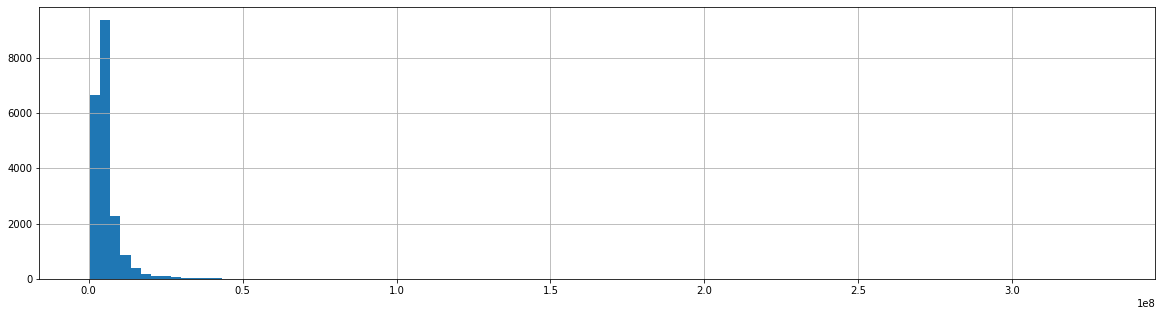

число комнат
count    20074.000000
mean         2.009166
std          1.014180
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


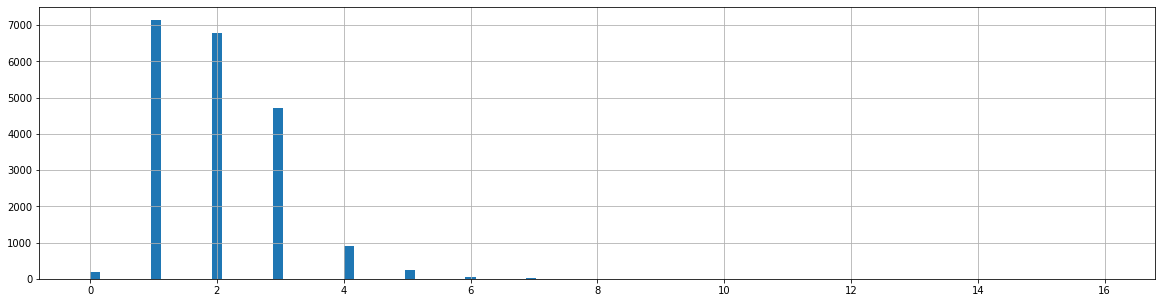

высота потолков
count    20074.000000
mean         2.685605
std          0.189637
min          2.400000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


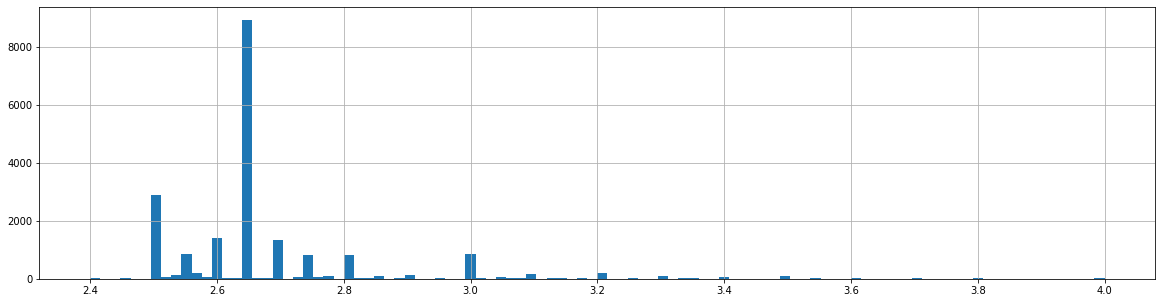

In [405]:
print('площадь')
print(data['total_area'].describe())
print(data['total_area'].hist(bins=100, figsize=(20,5)))
plt.show()
print('цена')
print(data['last_price'].describe())
print(data['last_price'].hist(bins=100, figsize=(20,5)))
plt.show()
print('число комнат')
print(data['rooms'].describe())
print(data['rooms'].hist(bins=100, figsize=(20,5)))
plt.show()
print('высота потолков')
print(data['ceiling_height'].describe())
print(data['ceiling_height'].hist(bins=100, figsize=(20,5)))
plt.show()

Изучение время продажи квартиры. Построение гистограммы. Расчёт среднего и медианы. Описание того, сколько обычно занимает продажа, и, когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

count    20074.000000
mean       180.042742
std        218.690988
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


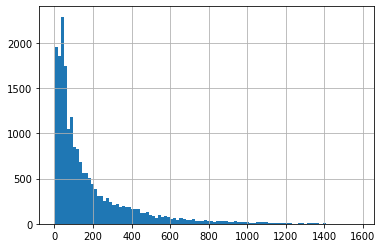

count    12818.000000
mean        72.448744
std         45.875623
min          9.000000
25%         36.000000
50%         60.000000
75%        104.000000
max        180.000000
Name: days_exposition, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


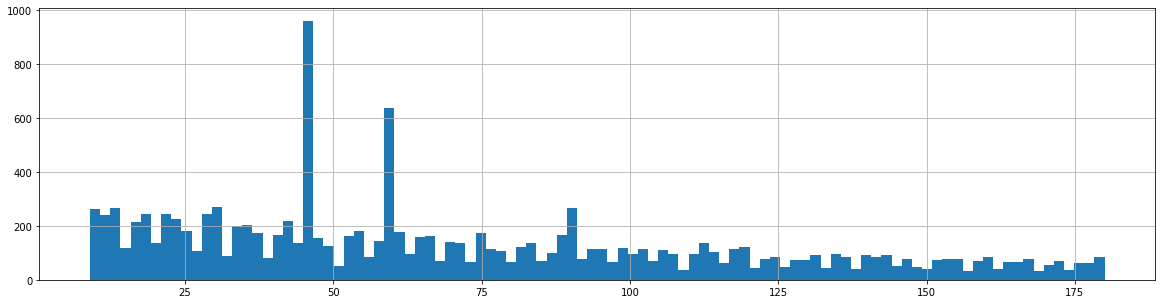

In [406]:
print(data['days_exposition'].describe())
print(data['days_exposition'].hist(bins=100))
plt.show()

data = data.query('9 <= days_exposition <= 180')
print(data['days_exposition'].describe())
print(data['days_exposition'].hist(bins=100, figsize=(20,5)))
plt.show()

Редкие и выбивающиеся значения - меньше 9 и больше 180.
Особенно часто квартиры продаются примерно на 45 и 60 день после объявления.

Описание того, какие факторы больше всего влияют на стоимость квартиры? Изучение того, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Изучение зависимости от даты размещения: дня недели, месяца и года.

In [407]:
print("Корреляция общей площади и цены за м2")
print(data['pr_m2'].corr(data['total_area']))
print()

print("Корреляция общей площади и общая цена ")
print(data['total_area'].corr(data['last_price']))
print()

print("Корреляция цена за м2 и количество комнат")
print(data['pr_m2'].corr(data['rooms']))
print()

print("Корреляция цена за м2 и этажа")
print(data['pr_m2'].corr(data['stage2']))
print()

print("Корреляция цена за м2 и центра")
print(data['pr_m2'].corr(data['cityCenters_nearest']))
print()

print("Корреляция цена за м2 и год")
print(data['pr_m2'].corr(data['year']))
print()

print("Корреляция цена за м2 и месяц")
print(data['pr_m2'].corr(data['month']))
print()

print("Корреляция цена за м2 и день недели")
print(data['pr_m2'].corr(data['weekday']))
print()

Корреляция общей площади и цены за м2
0.20296520329294987

Корреляция общей площади и общая цена 
0.6978342422453138

Корреляция цена за м2 и количество комнат
-0.02405316674958322

Корреляция цена за м2 и этажа
0.04150328621547086

Корреляция цена за м2 и центра
-0.35958541198950494

Корреляция цена за м2 и год
0.04752244144281207

Корреляция цена за м2 и месяц
0.00923261286604927

Корреляция цена за м2 и день недели
0.004000060572977308



Выводы:
чем больше общая площадь, тем дороже квадратный метр;
чем дальше от центра, тем меньше цена за квадратный метр;
больше площадь - больше цена;
со временем цена растёт.

10 населённых пунктов с наибольшим числом объявлений.

In [408]:
data_pivot_10locat = data.pivot_table(index='locality_name', values = 'pr_m2', aggfunc='mean')
N = data_pivot_10locat.sort_values('pr_m2', ascending = False).head(10)
N = N.reset_index()
print('Населённый пункт с самой высокой стоимостью жилья:', N.loc[0, 'locality_name'])
print('Населённый пункт с самой низкой стоимостью жилья:', N.loc[9, 'locality_name'])
print(N)

Населённый пункт с самой высокой стоимостью жилья: посёлок Лисий Нос
Населённый пункт с самой низкой стоимостью жилья: поселок Тельмана
       locality_name          pr_m2
0  посёлок Лисий Нос  168706.000000
1        Зеленогорск  127192.090909
2    Санкт-Петербург  109845.858388
3  деревня Мистолово  103216.000000
4         Сестрорецк  102856.457447
5             Пушкин   99261.830303
6            Кудрово   99110.290909
7   посёлок Левашово   96997.000000
8   посёлок Песочный   96345.000000
9   поселок Тельмана   93093.000000


Исследование по Санкт-Петербургу и его центру

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



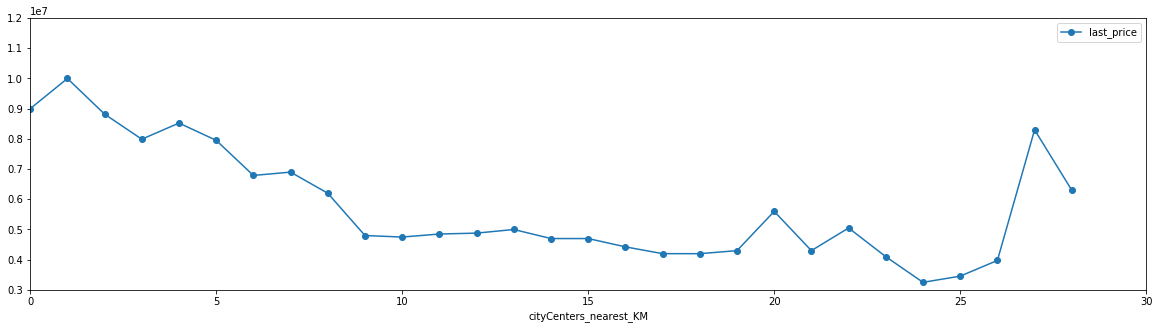

               График "Как цена зависит от удалённости от центра"


In [409]:
data_qS = data.query('locality_name == "Санкт-Петербург"')
data_qS['cityCenters_nearest'] = data_qS['cityCenters_nearest'].fillna(0)
data_qS['KM'] = 1000
data_qS['cityCenters_nearest_KM'] = (data_qS['cityCenters_nearest'] / data_qS['KM']).astype('int')
data_pivot_centr = data_qS.pivot_table(index='cityCenters_nearest_KM', 
                                       values = 'last_price', aggfunc='median')

data_pivot_centr = data_pivot_centr.reset_index()
data_pivot_centr.plot(x = 'cityCenters_nearest_KM', y = 'last_price', style = 'o-',
                      xlim=(0,30), ylim=(3000000, 12000000), figsize=(20,5), sharex=False)
plt.show()
print('               График "Как цена зависит от удалённости от центра"')

На 9 км будем считать заканчивается центр города, потому что на графике в этой точке встречаются 2 разнохарактерных тренда

Анализ центра и его параметры: площадь, цена, число комнат, высота потолков.

In [410]:
data_qCenter = data_qS.query('cityCenters_nearest_KM <= 9')
print('площадь')
print(data_qCenter['total_area'].describe(), 'Центр Санкт-Петербурга')
print(data_qS['total_area'].describe(), 'Санкт-Петербург в целом')
print('цена')
print(data_qCenter['last_price'].describe(), 'Центр Санкт-Петербурга')
print(data_qS['last_price'].describe(), 'Санкт-Петербург в целом')
print('количество комнат')
print(data_qCenter['rooms'].describe(), 'Центр Санкт-Петербурга')
print(data_qS['rooms'].describe(), 'Санкт-Петербург в целом')
print('высота потолков')
print(data_qCenter['ceiling_height'].describe(), 'Центр Санкт-Петербурга')
print(data_qS['ceiling_height'].describe(), 'Санкт-Петербург в целом')

площадь
count    2382.000000
mean       72.337750
std        39.921294
min        13.000000
25%        45.277500
50%        62.900000
75%        86.575000
max       500.000000
Name: total_area, dtype: float64 Центр Санкт-Петербурга
count    8488.000000
mean       58.271496
std        28.859278
min        13.000000
25%        40.000000
50%        51.000000
75%        67.800000
max       500.000000
Name: total_area, dtype: float64 Санкт-Петербург в целом
цена
count    2.382000e+03
mean     9.705338e+06
std      1.082168e+07
min      1.686000e+06
25%      5.100000e+06
50%      7.101396e+06
75%      1.070000e+07
max      2.300000e+08
Name: last_price, dtype: float64 Центр Санкт-Петербурга
count    8.488000e+03
mean     6.624965e+06
std      6.485082e+06
min      1.200000e+06
25%      4.000000e+06
50%      5.100000e+06
75%      7.150000e+06
max      2.300000e+08
Name: last_price, dtype: float64 Санкт-Петербург в целом
количество комнат
count    2382.000000
mean        2.381612
std         1

Квартиры в центре больше, дороже, часто высота потолков выше.

Факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).

Корреляция цена  и количество комнат
0.389519321468404 Центр
0.41352693238057986 Санкт-Петербург


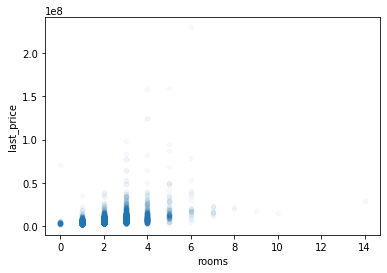


Корреляция цена  и этаж
0.06468874619410885 Центр
0.0549225798627367 Санкт-Петербург


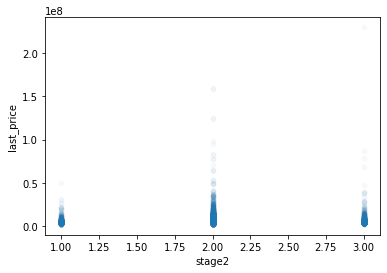


Корреляция цена  и расстояние от центра
-0.22336497714645187 Центр
-0.31602774077309337 Санкт-Петербург


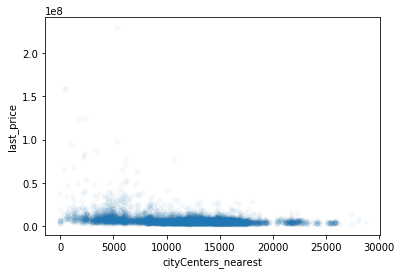


Корреляция цена  и дата размещения
-0.03818837143901486 Центр
-0.01206794827412627 Санкт-Петербург
Центр


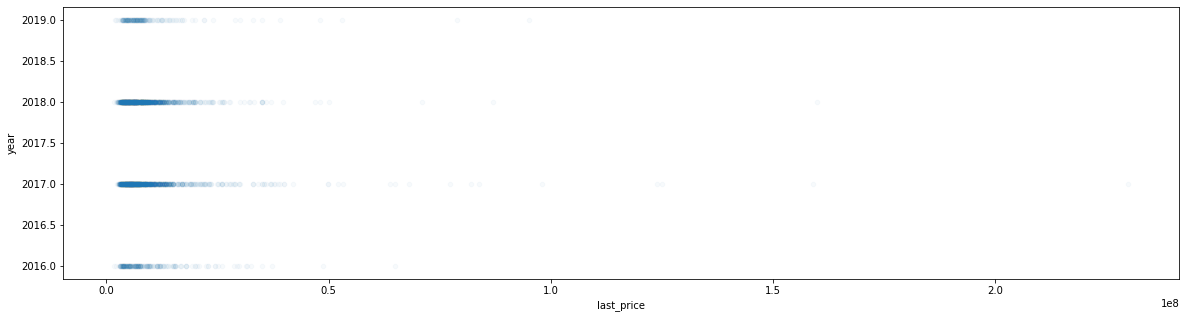

Санкт-Петербург


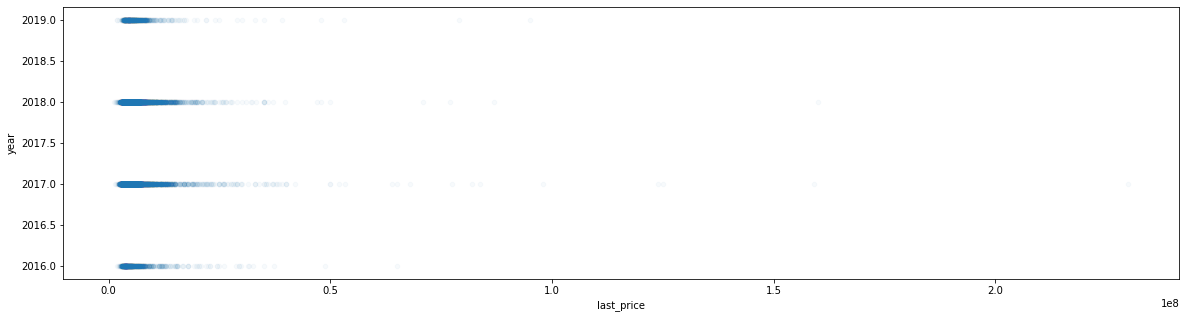

In [411]:
print("Корреляция цена  и количество комнат")
print(data_qCenter['last_price'].corr(data_qCenter['rooms']), 'Центр')
print(data_qS['last_price'].corr(data_qS['rooms']), 'Санкт-Петербург')
data_qS.plot(y='last_price', x='rooms', kind='scatter', alpha=0.03)
plt.show()
print()

print("Корреляция цена  и этаж")
print(data_qCenter['last_price'].corr(data_qCenter['stage2']), 'Центр')
print(data_qS['last_price'].corr(data_qS['stage2']), 'Санкт-Петербург')
data_qS.plot(y='last_price', x='stage2', kind='scatter', alpha=0.03)
plt.show()
print()

print("Корреляция цена  и расстояние от центра")
print(data_qCenter['last_price'].corr(data_qCenter['cityCenters_nearest']), 'Центр')
print(data_qS['last_price'].corr(data_qS['cityCenters_nearest']), 'Санкт-Петербург')
data_qS.plot(y='last_price', x='cityCenters_nearest', kind='scatter', alpha=0.03)
plt.show()
print()

print("Корреляция цена  и дата размещения")
print(data_qCenter['last_price'].corr(data_qCenter['year']), 'Центр')
print(data_qS['last_price'].corr(data_qS['year']), 'Санкт-Петербург')
print('Центр')
data_qCenter.plot(x='last_price', y='year', kind='scatter', alpha=0.03, figsize=(20,5))
plt.show()
print('Санкт-Петербург')
data_qS.plot(x='last_price', y='year', kind='scatter', alpha=0.03, figsize=(20,5))
plt.show()
print()

Цена сильно зависит в первую очередь от количества комнат(из рассматриваемых зависимостей)
во вторую - расстояние от центра, в третью - от этажа, во четвёртую - от даты размещения.

Если сравненивать по выше указанным параметрам, можно сделать следующий вывод:
Связь цены и даты размещения в центре в три раза сильнее, чем в Санкт-Петербург вцелом. Корреляция отрицательная, но чем дата ближе к сегодняшнему дню, тем цифра больше. Соответственно в центре цены на квартиры дорожают в три раза медленее. По остальным параметрам зависимости от цены мало отличаются.

### Шаг 5. Общий вывод

В среднем квартиры продаются до полугода, чаще в середине-в конце второго месяца. Цена за квадратный метр тем больше, чем больше общая площадь квартиры и близость к центру. В центре цены на квартиры дорожают в три раза медленее (последнее время).
Автоматическую систему определения расстояния до парков и озёр надо совершенствовать (встраивать лемматизацию и т.п.)